In [1]:
%%capture

import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from pandas_profiling import ProfileReport
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Decision Trees

- clean data with **outliers and missing values**
- use scikit-learn **pipelines**
- use scikit-learn for **decision trees**
- get and interpret **feature importances** of a tree-based model
- understand why decision trees are useful to model 

# I. Wrangle Data

In [3]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, na_values=[0, -2.000000e-08]), 
                  pd.read_csv(tv_path)).set_index('id')
  else:
    df = pd.read_csv(fm_path, na_values=[0, -2.000000e-08]).set_index('id')

  # Drop constant and repeated columns
  df.drop(columns=['recorded_by', 'extraction_type_group', 'quantity_group'], 
          inplace=True)
  
  # Drop columns with high % of NaN values
  df.dropna(axis=1, thresh=len(df)*.8, inplace=True)

  return df

In [4]:
df = wrangle(fm_path=DATA_PATH+'waterpumps/train_features.csv',
             tv_path=DATA_PATH+'waterpumps/train_labels.csv')

X_test = wrangle(fm_path=DATA_PATH+'waterpumps/test_features.csv')

In [5]:
# Check to see if the same columns are in training and test sets
set(df.columns).difference(set(X_test.columns))

{'status_group'}

# II. Split Data

## Split TV from FM

In [6]:
target = 'status_group'
y = df[target]
X = df.drop(columns=target)

## Training-Validation Split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish Baseline

- Is this a *regression* or a *classification* problem?
- Because it's a **classification** problem, we need to calculate baseline accuracy based on our majority class. 

In [8]:
y_train.value_counts(normalize=True)

functional                 0.542583
non functional             0.384352
functional needs repair    0.073066
Name: status_group, dtype: float64

In [9]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# IV. Build Model(s)

**First Model:** Logistic Regression

In [ ]:
# model_lr = make_pipeline(
#     OneHotEncoder(use_cat_names=True),
#     SimpleImputer(),
#     StandardScaler(),
#     LogisticRegression()
# )

# model_lr.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Second Model:** Decision Tree Classifier

In [11]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier()
)

model_dt.fit(X_train, y_train);

# V. Check Metrics

In [ ]:
print('Logistic Regresion training accuracy:', model_lr.score(X_train, y_train))
print('Logistic Regresion validation accuracy:', model_lr.score(X_val, y_val))

In [12]:
print('Decision Tree training accuracy:', model_dt.score(X_train, y_train))
print('Decision Tree validation accuracy:', model_dt.score(X_val, y_val))

Decision Tree training accuracy: 0.9999789557861066
Decision Tree validation accuracy: 0.6975589225589226


# Interlude: How does a tree model work?

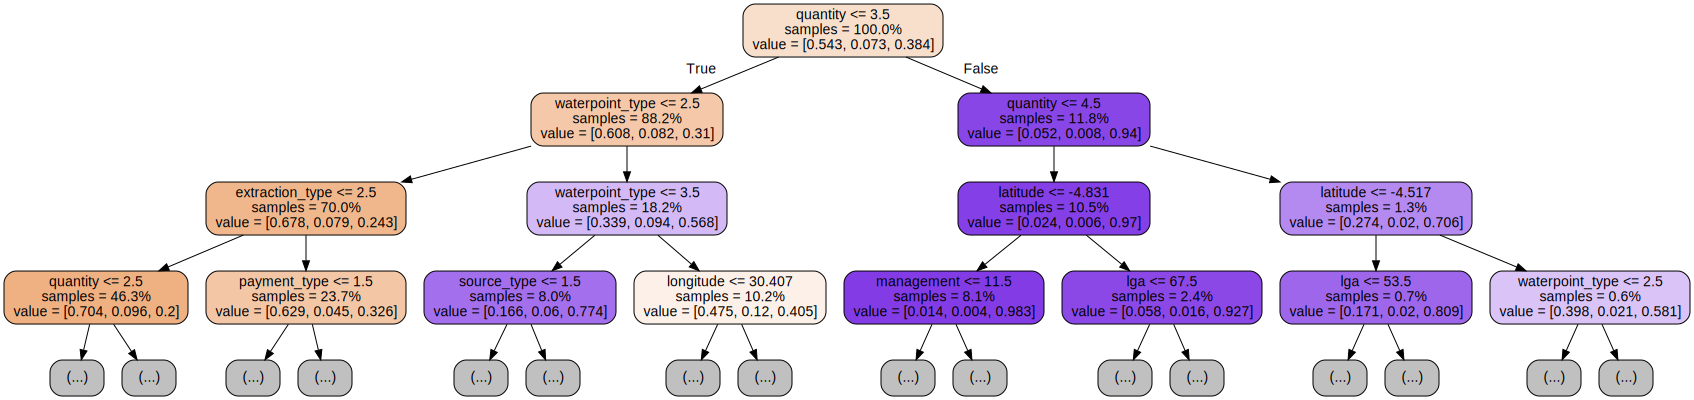

In [13]:
dot_data = export_graphviz(model_dt.named_steps['decisiontreeclassifier'], 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=X_train.columns,
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   

display(graphviz.Source(dot_data))

# VI. Communicate Results

Feature importance

# Interlude: What is overfitting?

- Let's look at the hyperparameter `max_depth`

In [14]:
depths = range(2,32,2)

train_acc = []
val_acc = []

for depth in depths:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      DecisionTreeClassifier(max_depth=depth, random_state=42)
  )

  tree_model.fit(X_train, y_train)

  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

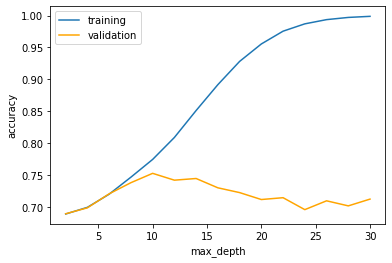

In [16]:
plt.plot(depths, train_acc, label='training')
plt.plot(depths, val_acc, color='orange', label='validation')

plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend();